#Introduction

We tried to override some methods of keras in order to customize how the loss function is evaluated.

### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/Challenge2_Mio

/gdrive/MyDrive/Challenge2_Mio


### Import libraries

In [3]:
title = 'CustomModel' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)

### Load the dataset

In [6]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


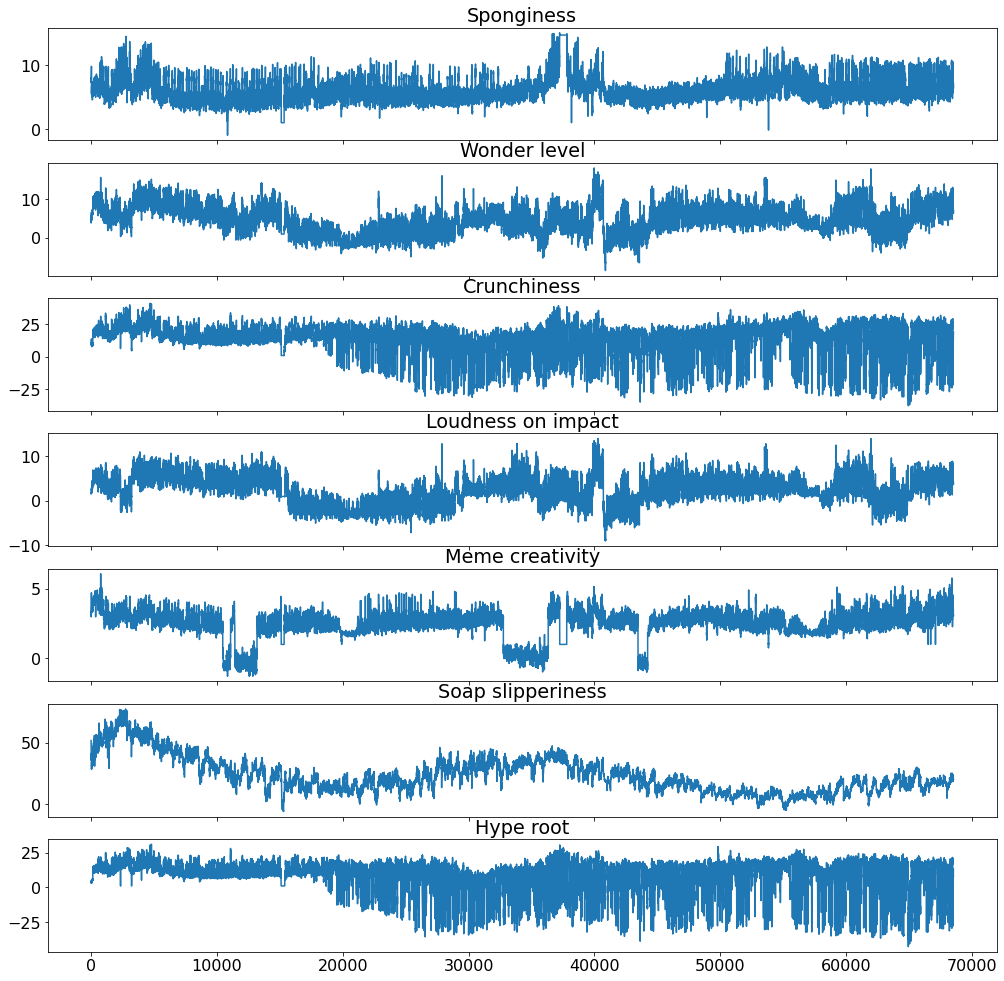

In [7]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

(63528, 7) (5000, 7)


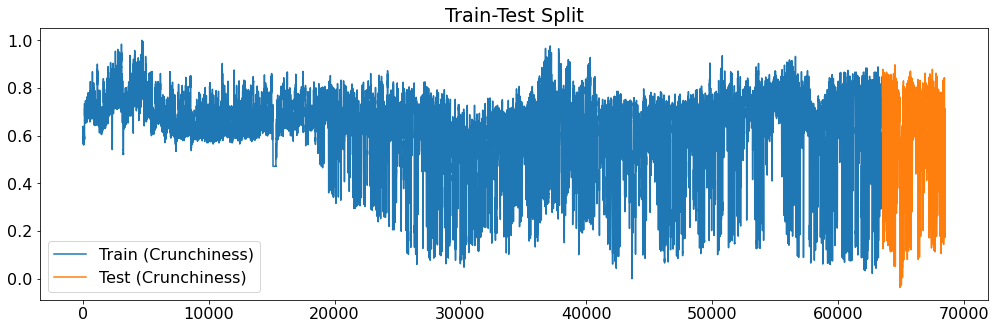

In [8]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [9]:
# values for window and stride
direct_window = 450
direct_stride = 10

ar_window = 450
ar_stride = 10

general_telescope = 50

batch_given = 128 # batch size

In [10]:
future = dataset[-direct_window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
print(future.shape)

(1, 450, 7)


In [11]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=50):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### Multivariate Forecating (Direct)

In [12]:
target_labels = dataset.columns
telescope = general_telescope

In [13]:
X_train, y_train = build_sequences(X_train_raw, target_labels, direct_window, direct_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, direct_window, direct_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6340, 450, 7), (6340, 50, 7), (490, 450, 7), (490, 50, 7))

In [14]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0, 1)
    plt.show()

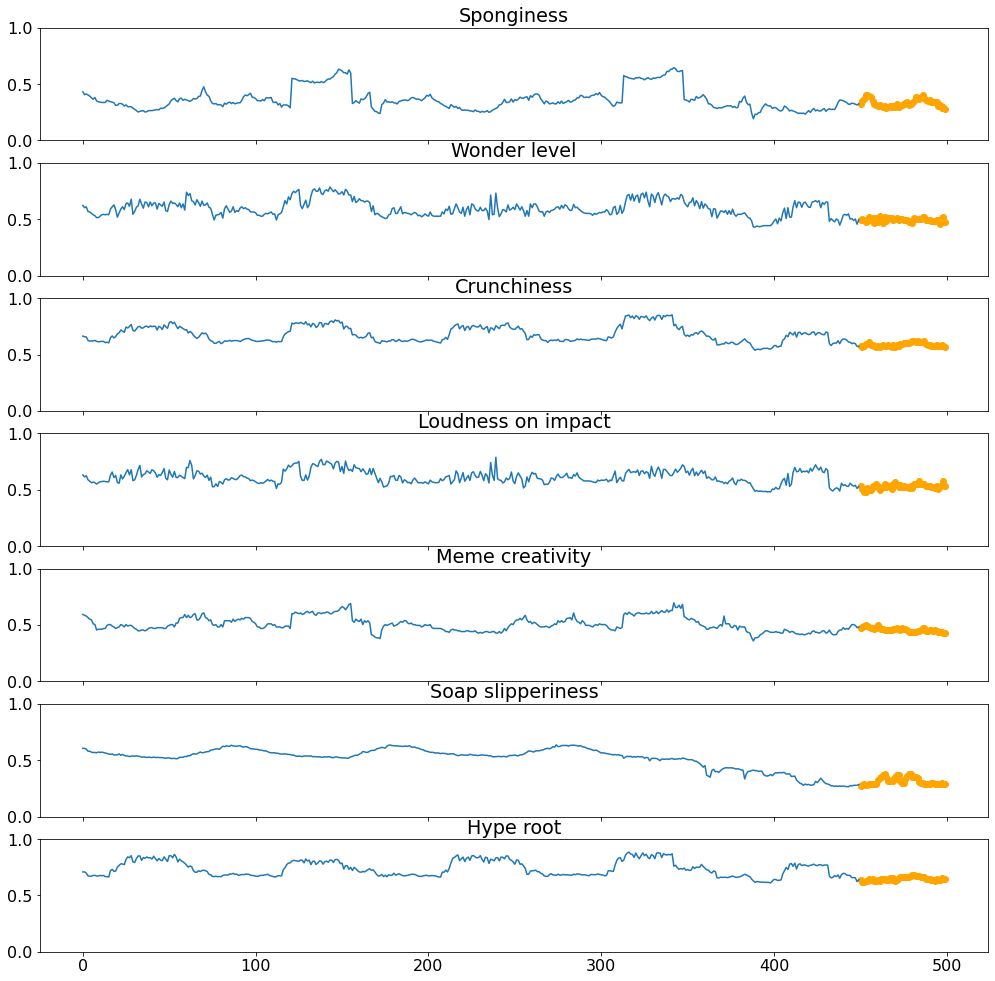

In [15]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [16]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = batch_given
epochs = 300

In [17]:
from keras.engine import data_adapter

# overriding train step 
class CustomTrainStep(tf.keras.Model):
    def __init__(self, n_gradients, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def train_step(self, data):
      x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)
      # Run forward pass.
      
      X_temp = x
      first = True
      with tf.GradientTape() as tape:
        # We repeat the Autoregressive procedure for the first 5 points
        for i in range(5):
          y_pred_full = self(X_temp, training=True)
          y_pred = y_pred_full[:,0,:]
          y_pred = tf.expand_dims(y_pred, 1)
          if first:
            reg_predictions = y_pred
            first = False
          else:
            reg_predictions = tf.concat((reg_predictions,y_pred),axis=1)
          X_temp = tf.concat((X_temp[:,1:,:],y_pred), axis=1)

        # We repeat the Autoregressive procedure for the first 5 points and we add the prediction of the other values
        reg_predictions = tf.concat((reg_predictions,y_pred_full[:,5:,:]),axis=1)
        #x = tfk.constant(X_temp)
        loss = self.compute_loss(x, y, reg_predictions, sample_weight)
        
      self._validate_target_and_loss(y, loss)
      # Run backwards pass.
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
      return self.compute_metrics(x, y, reg_predictions, sample_weight)


    def compute_loss(self, x, y, y_pred, sample_weight):
      del x  # The default implementation does not use `x`.
      return self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)

    def _validate_target_and_loss(self, y, loss):
      if self.loss and y is None:
        raise ValueError(
            'Target data is missing. Your model was compiled with '
            f'loss={self.loss}, '
            'and therefore expects target data to be provided in `fit()`.')


      elif loss is None:
        raise ValueError(
            'No loss found. You may have forgotten to provide a `loss` argument '
            'in the `compile()` method.')
        
    def compute_metrics(self, x, y, y_pred, sample_weight):
      del x  # The default implementation does not use `x`.
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
      # Collect metrics to return
      return_metrics = {}
      for metric in self.metrics:
        result = metric.result()
        if isinstance(result, dict):
          return_metrics.update(result)
        else:
          return_metrics[metric.name] = result
      return return_metrics


        
# Model 
input_layer = tfkl.Input(shape=input_shape, name='Input')
cnn = tfkl.Conv1D(128,7,padding='same',activation='relu')(input_layer)
cnn = tfkl.MaxPooling1D()(cnn)
cnn = tfkl.Conv1D(128,5,padding='same',activation='relu')(input_layer)
cnn = tfkl.MaxPooling1D()(cnn)
cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
cnn = tfkl.MaxPooling1D()(cnn)
lstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(cnn)
lstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(lstm)
lstm = tfkl.GlobalAveragePooling1D()(lstm)
lstm = tfkl.Dropout(.55)(lstm)

# In order to predict the next values for more than one sensor,
# we can use a Dense layer with a number given by telescope*num_sensors,
# followed by a Reshape layer to obtain a tensor of dimension 
# [None, telescope, num_sensors]
dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(lstm)
output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense) 
custom_model = CustomTrainStep(n_gradients=10, inputs=[input_layer], outputs=[output_layer])

# bind all
custom_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(learning_rate=0.0005), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])


model = custom_model

Model: "custom_train_step"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 450, 7)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 450, 128)          2816      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 225, 128)         0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 225, 512)         788480    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 225, 512)         1574912   
 nal)                                                            
                                                 

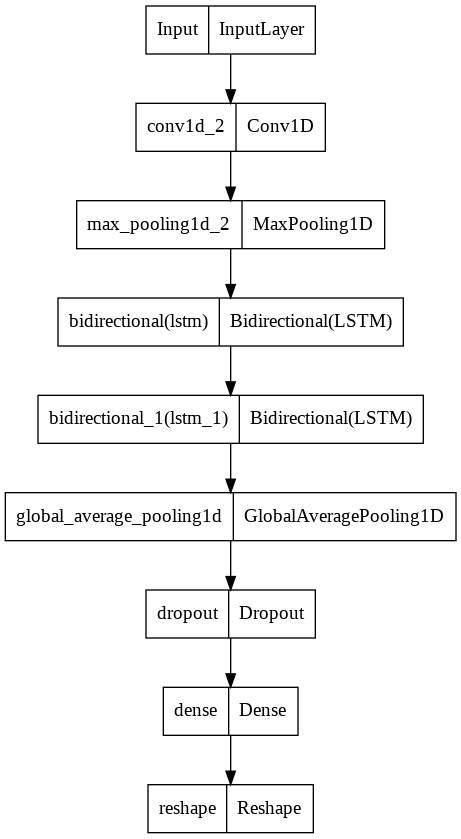

In [18]:
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [19]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=20, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=10, factor=0.5, min_lr=1e-7)
  callbacks.append(es2_callback)

  return callbacks

In [20]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

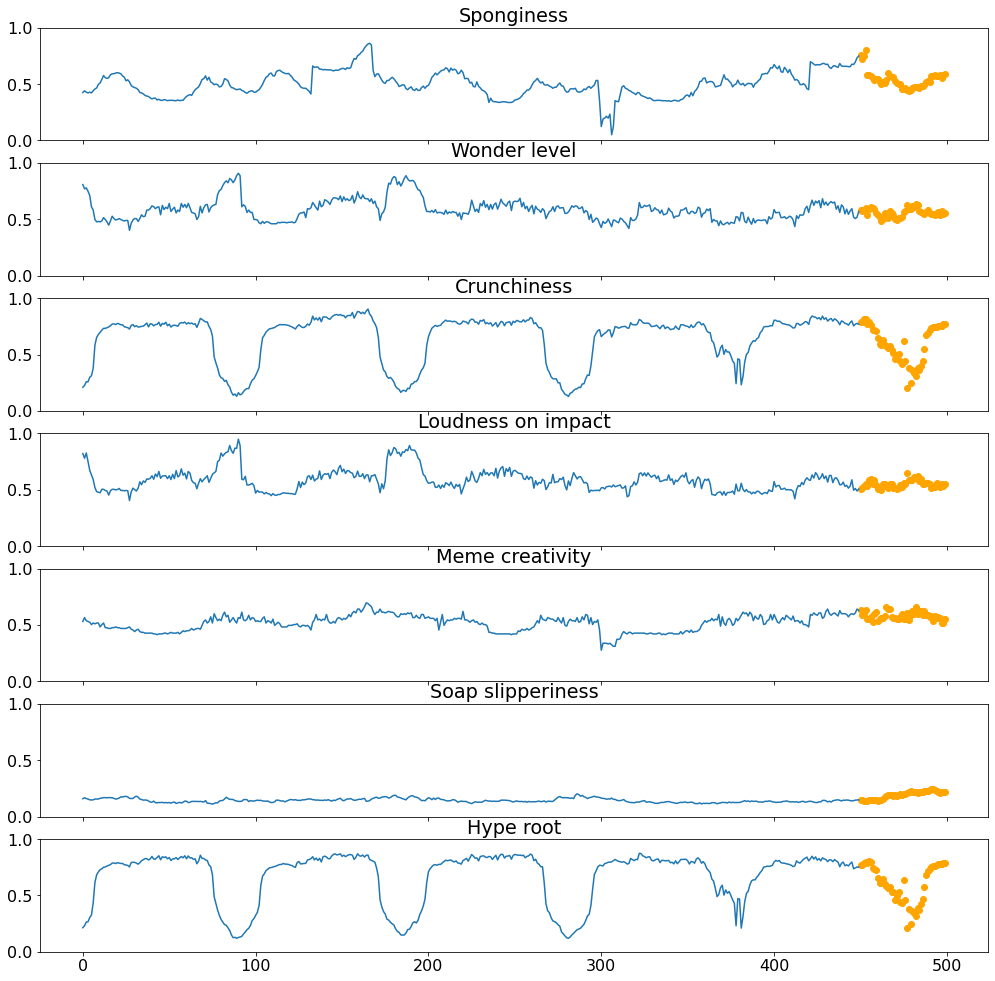

In [21]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [22]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = batch_given
epochs = 200

In [ ]:
tl_callbacks = create_folders_and_callbacks(model_name = ''+title+'')

# customized fit 
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = tl_callbacks
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [24]:
#model.save('Models/'+title+'AuroregressiveForecasting')
model = tfk.models.load_model('../Challenge2_Mio/Models/CustomModel')

In [25]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(490, 50, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.032830145>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.10473173>)

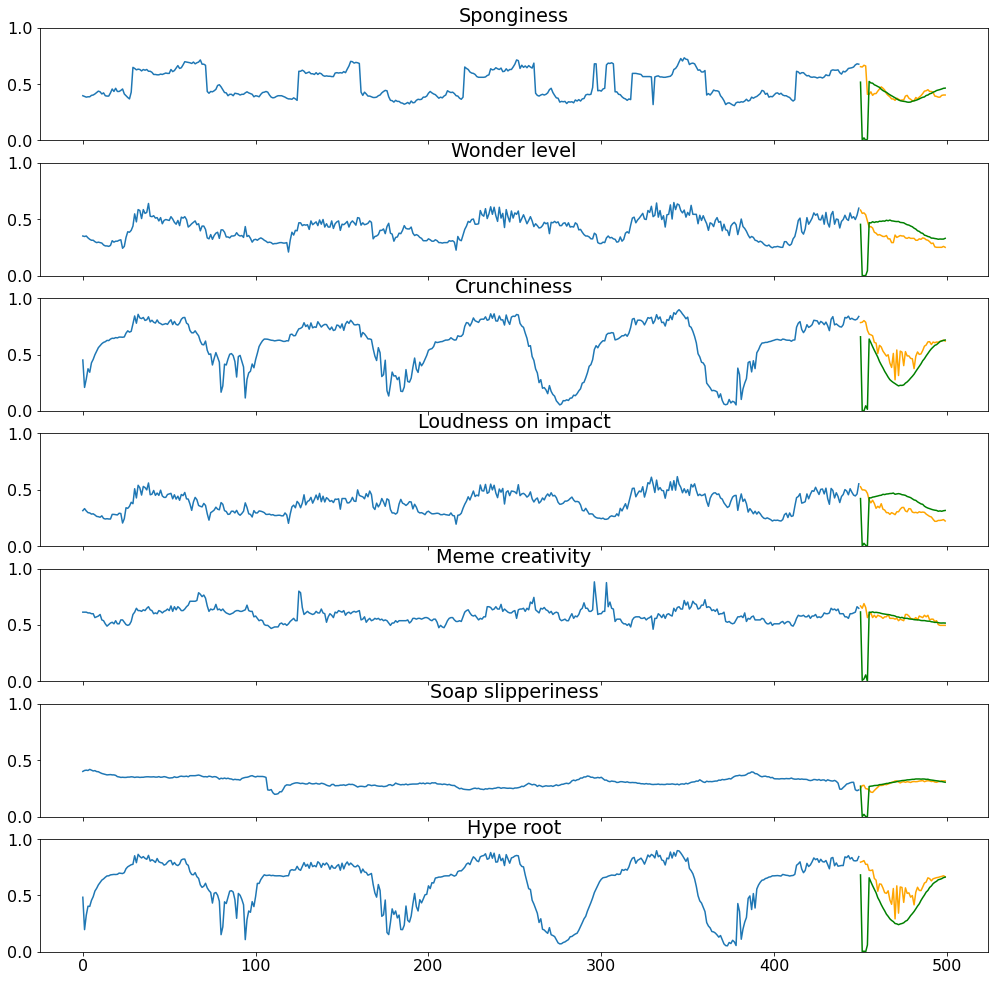

In [26]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

In [27]:
reg_telescope = 864
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

((409, 450, 7), (409, 864, 7))

In [28]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)[:,0:1,:]
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [29]:
reg_predictions.shape

(409, 864, 7)

In [30]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.017268654>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.095306724>)

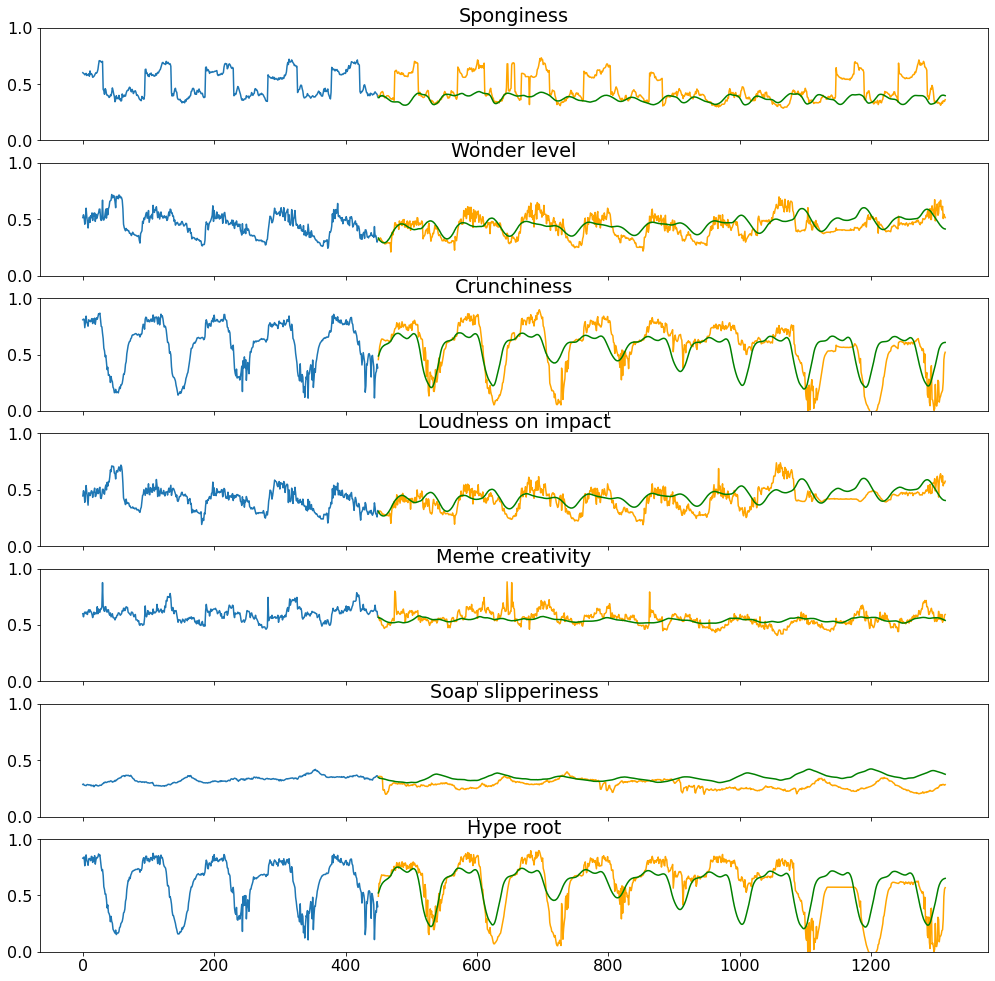

In [31]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)